In [1]:
import imp
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

import util
from plot_core import PlotAx, STYLE_PATH
from util import *
from data_loader import LoadRealCris
from plot_model_training import *
from spectrum_conversion import iasi2hiras

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

/home/cali/bin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

Using TensorFlow backend.


In [3]:
style_file = os.path.join(STYLE_PATH, 'plot_regression.mplstyle')
plt.style.use(style_file)

In [4]:
in_dir = '/home/cali/data/GapFilling/FY4A+GIIRS_Metop+IASI'
in_dir2 = '/home/cali/data/GapFilling/FY4A+GIIRS_Metop+IASI'
pic_dir = 'Picture'
result_dir = 'Result'
data_dir = 'Data'
model_dir = 'Model'
for _dir in [pic_dir, result_dir, data_dir, model_dir]:
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
    print(_dir)

Picture
Result
Data
Model


# iasi2giirs

In [5]:
IASI_F_NYQUIST = 6912.0  # 频带宽度  cm-1
IASI_RESAMPLE_MAXX = [2.0, ]  # cm OPD
IASI_D_FREQUENCY = [0.25, ]  # v cm-1  光谱分辨率
IASI_BAND_F1 = [645.25, ]  # 光谱带开始
IASI_BAND_F2 = [2760.25, ]  # 光谱带结束
IASI_FILTER_WIDTH = [20.0, ]  # cm-1  # COS过滤器过滤的宽度

GIIRS_F_NYQUIST = 5875.0
GIIRS_RESAMPLE_MAXX = [0.8, ]
GIIRS_D_FREQUENCY = [0.625, ]
GIIRS_BAND_F1 = [650.00, ]
GIIRS_BAND_F2 = [2755.00, ]
GIIRS_FILTER_WIDTH = [20.0, ]

In [6]:
def get_data_by_wavenumber_range(df_data, wavenumber, ranges):
    """
    根据波数和波数范围获取数据
    :param df_data: pd.DataFrame 格式
    :param wavenumber: 波数
    :param ranges: 波段范围和分辨率 [(start, end, frequency),]
    :return:
    """
    if not isinstance(df_data, pd.DataFrame):
        df_data = pd.DataFrame(df_data)

    wavenumber = wavenumber.tolist()
    idx = list()
    for range_s, range_e, _ in ranges:
        idx_s = wavenumber.index(range_s)
        idx_e = wavenumber.index(range_e)
        idx_tmp = [i for i in range(idx_s, idx_e+1)]
        if idx is None:
            idx = idx_tmp
        else:
            idx.extend(idx_tmp)
    return df_data.loc[:, idx]

# 合成全部的Real CRIS数据

In [7]:
class LoadGiirsCris(object):
    """
    读取GIIRS和CRIS的匹配数据
    """
    def __init__(self, in_file):
        self.in_file = in_file
        self.wn_giirs = [(700., 1130., 0.625), (1650., 2250., 0.625),]
        self.wn_cris = [(650., 1095., 0.625), ] 
    
    def get_giirs_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('GEO_Spectrum_rad')[:].T
        return rad
#     def get_giirs_radiance(self):
#         with h5py.File(self.in_file) as hdf5:
#             rad = hdf5.get('GEO_Spectrum_rad')[:].T
#             rad = pd.DataFrame(rad)
#         wavenumber = self.get_giirs_wavenumber()

#         real_lw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[0:1])
#         real_mw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[1:2])
        
#         real_lw = np.array(real_lw)
#         real_mw = np.array(real_mw)
        
#         w0 = 0.23
#         w1 = 0.54
#         w2 = 0.23
#         real_lw[:, 1:-1] = w0 * real_lw[:, :-2] + w1 * real_lw[:, 1:-1] + w2 * real_lw[:, 2:]
#         real_mw[:, 1:-1] = w0 * real_mw[:, :-2] + w1 * real_mw[:, 1:-1] + w2 * real_mw[:, 2:]
#         response = np.concatenate((real_lw, real_mw), axis=1)
#         return response

    def get_cris_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('LEO_Spectrum_rad')[0:713].T
#         w0 = 0.23
#         w1 = 0.54
#         w2 = 0.23
#         rad[:, 1:-1] = w0 * rad[:, :-2] + w1 * rad[:, 1:-1] + w2 * rad[:, 2:]
        return rad
    
    def get_giirs_wavenumber(self):
        return get_wavenumber_by_range(self.wn_giirs)

    def get_cris_wavenumber(self):
        return get_wavenumber_by_range(self.wn_cris)
        

In [8]:
def load_all_matched_data_giirs_cris(in_files):
    response_all_giirs = None
    wavenumber_giirs = None
    for in_file in in_files:
        response_giirs = LoadGiirsCris(in_file).get_giirs_radiance()
        if response_all_giirs is None:
            response_all_giirs = response_giirs
        else:
            response_all_giirs = np.concatenate((response_all_giirs, response_giirs), axis=0)
        if wavenumber_giirs is None:
            wavenumber_giirs = LoadGiirsCris(in_file).get_giirs_wavenumber()
    
    response_all_cris = None
    wavenumber_cris = None
    for in_file in in_files:
        response_cris = LoadGiirsCris(in_file).get_cris_radiance()
        if response_all_cris is None:
            response_all_cris = response_cris
        else:
            response_all_cris = np.concatenate((response_all_cris, response_cris), axis=0)
        if wavenumber_cris is None:
            wavenumber_cris = LoadGiirsCris(in_file).get_cris_wavenumber()
    
    return pd.DataFrame(response_all_giirs), pd.DataFrame(response_all_cris), wavenumber_giirs, wavenumber_cris

In [9]:
class LoadGiirsIasi(object):
    """
    读取GIIRS和IASI的匹配数据
    """
    def __init__(self, in_file):
        self.in_file = in_file
        self.wn_giirs = [(700., 1130., 0.625), (1650., 2250., 0.625),]
        self.wn_iasi = [(650., 2755., 0.625), ] 
        
    def get_giirs_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('giirs_rad')[:].T
        wavenumber = self.get_giirs_wavenumber()
    
        real_lw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[0:1])
        real_mw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[1:2])
        
        real_lw = np.array(real_lw)
        real_mw = np.array(real_mw)
        
        w0 = 0.23
        w1 = 0.54
        w2 = 0.23
        real_lw[:, 1:-1] = w0 * real_lw[:, :-2] + w1 * real_lw[:, 1:-1] + w2 * real_lw[:, 2:]
        real_mw[:, 1:-1] = w0 * real_mw[:, :-2] + w1 * real_mw[:, 1:-1] + w2 * real_mw[:, 2:]
        response = np.concatenate((real_lw, real_mw), axis=1)
        return response

    def get_iasi_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('iasi_rad_ori')[:].T
            iband = 0
            rad_new = None
            for radiance in rad:
                spec_iasi2giirs, wavenumber_iasi2giirs, plot_data_iasi2giirs = iasi2hiras(
                    radiance, IASI_BAND_F1[iband], IASI_BAND_F2[iband], IASI_D_FREQUENCY[iband],
                    GIIRS_BAND_F1[iband], GIIRS_BAND_F2[iband], GIIRS_D_FREQUENCY[iband],
                    GIIRS_F_NYQUIST, GIIRS_RESAMPLE_MAXX[iband], GIIRS_FILTER_WIDTH[iband],
                    apodization_ori=iasi_apod, )
                if rad_new is None:
                    rad_new = spec_iasi2giirs.reshape(1, -1)
                else:
                    rad_new = np.concatenate((rad_new, spec_iasi2giirs.reshape(1, -1)), axis=0)
        return rad_new

    def get_giirs_wavenumber(self):
        return get_wavenumber_by_range(self.wn_giirs)

    def get_iasi_wavenumber(self):
        return get_wavenumber_by_range(self.wn_iasi)

In [10]:
def load_all_matched_data_giirs_iasi(in_files):
    response_all_giirs = None
    wavenumber_giirs = None
    for in_file in in_files:
        response_giirs = LoadGiirsIasi(in_file).get_giirs_radiance()
        if response_all_giirs is None:
            response_all_giirs = response_giirs
        else:
            response_all_giirs = np.concatenate((response_all_giirs, response_giirs), axis=0)
        if wavenumber_giirs is None:
            wavenumber_giirs = LoadGiirsCris(in_file).get_giirs_wavenumber()
    
    response_all_iasi = None
    wavenumber_iasi = None
    for in_file in in_files:
        response_iasi = LoadGiirsIasi(in_file).get_iasi_radiance()
        if response_all_iasi is None:
            response_all_iasi = response_iasi
        else:
            response_all_iasi = np.concatenate((response_all_iasi, response_iasi), axis=0)
        if wavenumber_iasi is None:
            wavenumber_iasi = LoadGiirsIasi(in_file).get_iasi_wavenumber()
    
    return pd.DataFrame(response_all_giirs), pd.DataFrame(response_all_iasi), wavenumber_giirs, wavenumber_iasi

# 加载全部波段数据

In [11]:
real_files = [os.path.join(in_dir, i) for i in os.listdir(in_dir)]

In [12]:
data_all_x, data_all_y, wavenumber_x, wavenumber_y = load_all_matched_data_giirs_iasi(real_files)

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000

n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500 2581 11040 11121
47000
47000
idx_trunc 9400
n_ifg_other 9401
18800
18800
23501
2580 11041
2500

In [13]:
print(data_all_x.shape)
print(data_all_y.shape)

(867, 1650)
(867, 3369)


In [14]:
wavenumber_compare = [(700, 1130, 0.625), (1650, 2250, 0.625)]

In [15]:
data_all_x_part = get_data_by_wavenumber_range(data_all_x, wavenumber_x, wavenumber_compare)
wavenumber_x_part = get_wavenumber_by_range(wavenumber_compare)

In [16]:
data_all_y_part = get_data_by_wavenumber_range(data_all_y, wavenumber_y, wavenumber_compare)
wavenumber_y_part = get_wavenumber_by_range(wavenumber_compare)

In [17]:
print(type(data_all_x_part))
print(data_all_x_part.shape)

print(type(data_all_y_part))
print(data_all_y_part.shape)

# 判断是否有小于0和等于nan的无效值
print(np.where(data_all_x_part<=0)[0].shape)
print(np.where(np.isnan(data_all_x_part))[0].shape)

# 判断是否有小于0和等于nan的无效值
print(np.where(data_all_y_part<=0)[0].shape)
print(np.where(np.isnan(data_all_y_part))[0].shape)

<class 'pandas.core.frame.DataFrame'>
(867, 1650)
<class 'pandas.core.frame.DataFrame'>
(867, 1650)
(0,)
(0,)
(0,)
(0,)


In [18]:
tbb_all_x_part = np.array(rad2tbb(data_all_x_part, wavenumber_x_part))
tbb_all_y_part = np.array(rad2tbb(data_all_y_part, wavenumber_y_part))

result = tbb_all_x_part - tbb_all_y_part
result_mean1 = np.nanmean(result, axis=0)

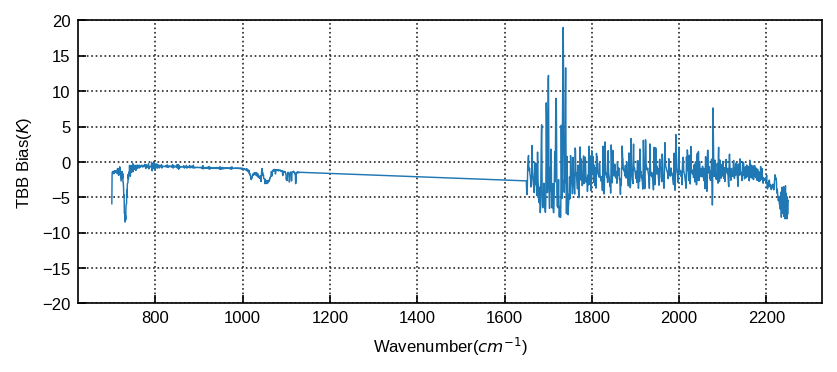

In [20]:
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, result_mean1, lw=0.7)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.ylim(-20, 20)
plt.show()

# 预测通道与CRIS的对比

In [21]:
wavenumber_compare = get_wavenumber_by_range([(700, 2250., 0.625),])

In [22]:
X_data = get_data_by_wavenumber_range(data_all_x, wavenumber_x, [(760., 1050., 0.625), (1800., 2188.125, 0.625),])

In [23]:
model_name = 'test_giirs_xuhui'
linear_model_attribute_file_business = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
coef, intercept = get_linear_model_attributes(linear_model_attribute_file_business)

In [24]:
Y_predict = X_data.dot(coef) + intercept

In [25]:
print(Y_predict.shape)
print(type(Y_predict))

(867, 1394)
<class 'pandas.core.frame.DataFrame'>


In [26]:
ranges_Y_all = [(700, 759.375, 0.625), (1050.625, 1130, 0.625),
                (1130.625, 1649.375, 0.625), (1650., 1799.375, 0.625), (2188.75, 2250., 0.625),
               ]

In [27]:
wavenumber_y_predict = get_wavenumber_by_range(ranges_Y_all)

In [28]:
data_x_part1 = get_data_by_wavenumber_range(Y_predict, wavenumber_y_predict, [(700, 759.375, 0.625), ])

In [29]:
data_x_part2 = get_data_by_wavenumber_range(data_all_x, wavenumber_x, [(760., 1050., 0.625),])

In [30]:
data_x_part3 = get_data_by_wavenumber_range(Y_predict, wavenumber_y_predict, [(1050.625, 1130, 0.625), ])

In [31]:
data_x_part4 = get_data_by_wavenumber_range(Y_predict, wavenumber_y_predict, [(1130.625, 1649.375, 0.625), ])

In [32]:
data_x_part5 = get_data_by_wavenumber_range(Y_predict, wavenumber_y_predict, [(1650., 1799.375, 0.625), ])

In [33]:
data_x_part6 = get_data_by_wavenumber_range(data_all_x, wavenumber_x, [(1800., 2188.125, 0.625),])

In [34]:
data_x_part7 = get_data_by_wavenumber_range(Y_predict, wavenumber_y_predict, [(2188.75, 2250, 0.625), ])

In [35]:
data_x_part_new = np.concatenate((data_x_part1, data_x_part2, data_x_part3, data_x_part4, data_x_part5, data_x_part6, data_x_part7), axis=1)

In [36]:
print(data_x_part_new.shape)

(867, 2481)


In [37]:
data_y_part = get_data_by_wavenumber_range(data_all_y, wavenumber_y, [(700, 2250., 0.625),])

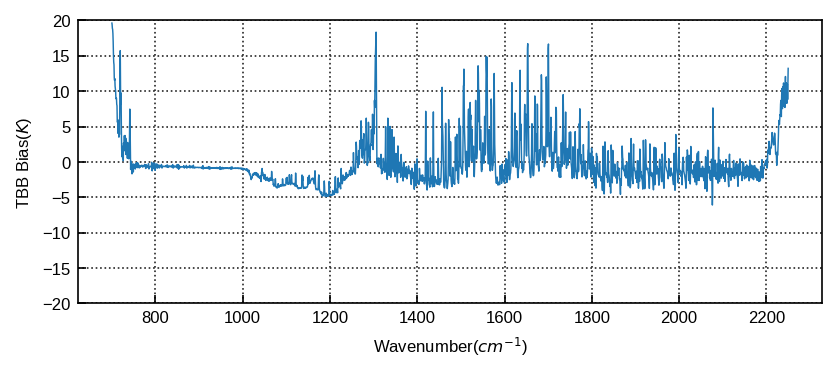

In [39]:
tbb_x_part = np.array(rad2tbb(data_x_part_new, wavenumber_compare))
tbb_y_part = np.array(rad2tbb(data_y_part, wavenumber_compare))

result = tbb_x_part - tbb_y_part
result_mean2 = np.nanmean(result, axis=0)

figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_compare, result_mean2, lw=0.7)
plt.ylim(-20, 20)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()


In [40]:
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_compare, result_mean2 - result_mean1, lw=0.7)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

ValueError: operands could not be broadcast together with shapes (2481,) (1650,) 

<Figure size 960x375 with 0 Axes>

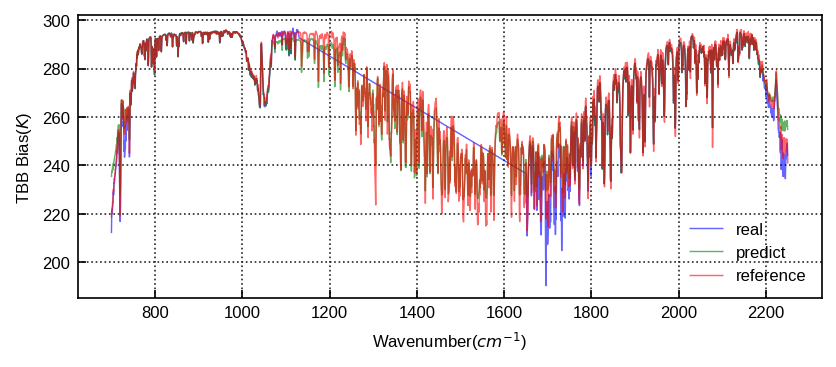

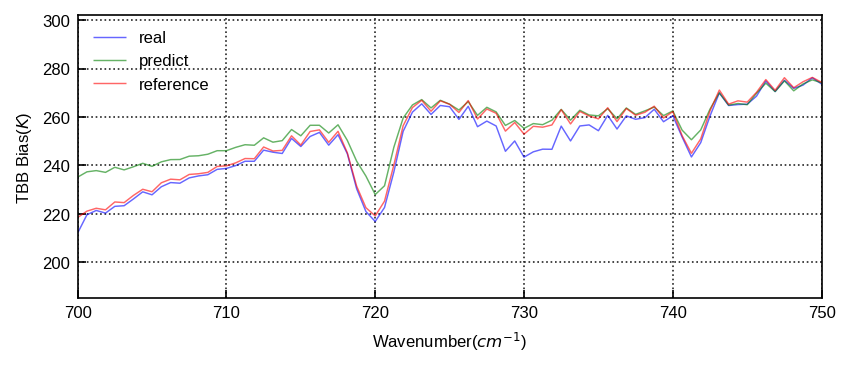

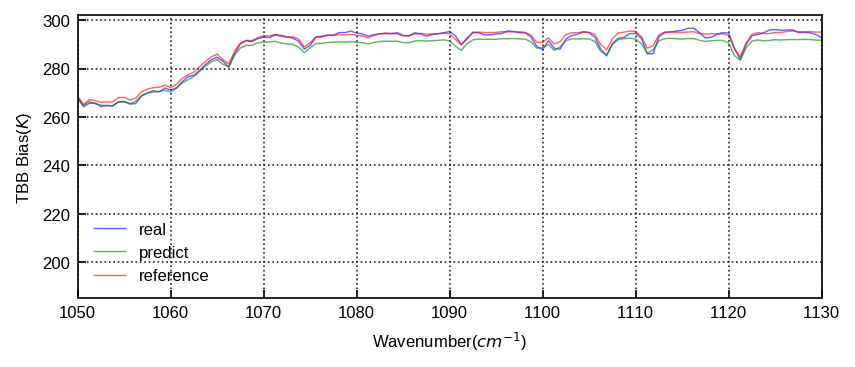

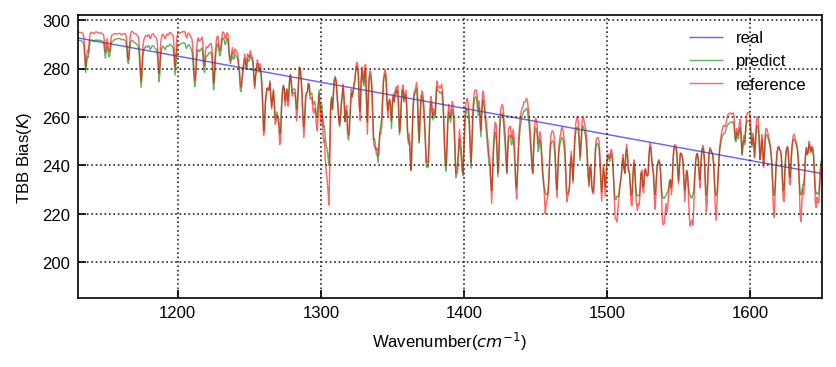

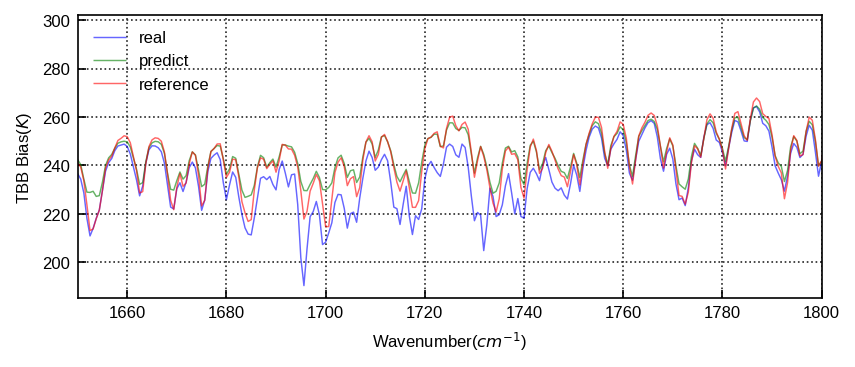

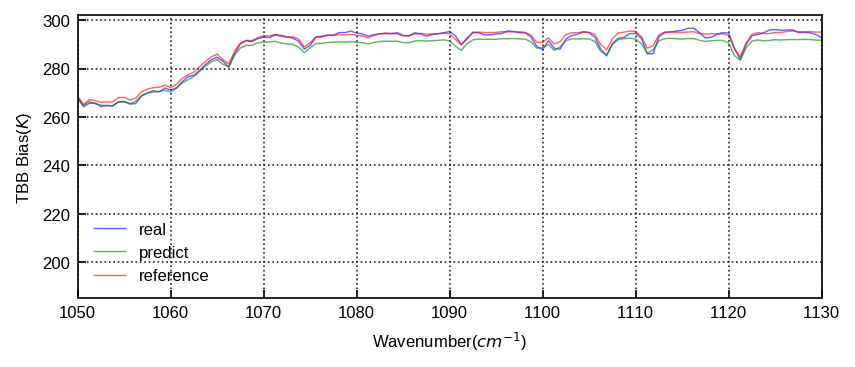

In [41]:
data_number = 1
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_compare, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_compare, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='reference')
plt.legend()
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_compare, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_compare, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='reference')
plt.legend()
plt.xlim(700, 750)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_compare, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_compare, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='reference')
plt.legend()
plt.xlim(1050, 1130)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_compare, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_compare, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='reference')
plt.legend()
plt.xlim(1130, 1650)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_compare, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_compare, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='reference')
plt.legend()
plt.xlim(1650, 1800)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_compare, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_compare, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='reference')
plt.legend()
plt.xlim(1050, 1130)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

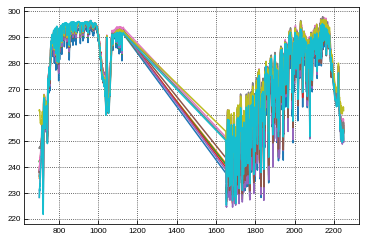

In [577]:
for i in range(0, 10):
    plt.plot(wavenumber_x_part, tbb_x_part[i])
plt.show()

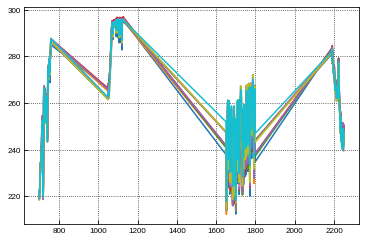

In [520]:
for i in range(0, 10):
    plt.plot(wavenumber_x_part, tbb_y_part[i])
plt.show()